In [1]:
import re, os
import unicodedata
import json

import pandas as pd
import numpy as np
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
import nltk.sentiment
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from time import strftime

from wordcloud import WordCloud

from pprint import pprint

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer


from requests import get
from bs4 import BeautifulSoup

from wordcloud import WordCloud

import acquire
import acquire_jg
import prepare_jag


plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-darkgrid')

pd.set_option('display.max_rows', 200)


---

## Acquire data

In [2]:
""" def get_all_repository_urls(url): # repository url
    # Get max page.
    response = get(url)
    soup = BeautifulSoup(response.text)
    print('Finding max page for repositories...')
    max_page = int(soup.find('div', role='navigation').text[-6])
    print(f'Max page found: {max_page}')
    page = 1
    repository_links = []
    print('Starting loop...')
    for n in range(max_page):
        print(n+1, 'iteration')
        print(f'Pulling data from {url}')
        # Reset soup.
        response = get(url)
        soup = BeautifulSoup(response.text)
        # Get all the repositories from the page.
        repositories = soup.find_all('a', itemprop='name codeRepository') 
        print('Fetching links for repositories...')
        for repo in repositories:
            repository_links.append(repo.get('href'))
        git = 'https://github.com/'
        next_page = soup.find('a', class_='next_page').get('href')[:-1]
        ## Use this line of code to get the url for the next page.
        if page <= 4:
            url = git + next_page + str(page + 1)
            page += 1
        else:
            return repository_links
 """

" def get_all_repository_urls(url): # repository url\n    # Get max page.\n    response = get(url)\n    soup = BeautifulSoup(response.text)\n    print('Finding max page for repositories...')\n    max_page = int(soup.find('div', role='navigation').text[-6])\n    print(f'Max page found: {max_page}')\n    page = 1\n    repository_links = []\n    print('Starting loop...')\n    for n in range(max_page):\n        print(n+1, 'iteration')\n        print(f'Pulling data from {url}')\n        # Reset soup.\n        response = get(url)\n        soup = BeautifulSoup(response.text)\n        # Get all the repositories from the page.\n        repositories = soup.find_all('a', itemprop='name codeRepository') \n        print('Fetching links for repositories...')\n        for repo in repositories:\n            repository_links.append(repo.get('href'))\n        git = 'https://github.com/'\n        next_page = soup.find('a', class_='next_page').get('href')[:-1]\n        ## Use this line of code to get the 

In [3]:
#repository_links = get_all_repository_urls('https://github.com/orgs/apple/repositories')

In [4]:
df = pd.read_json('data.json')

In [5]:
df.language.value_counts()

Swift               65
Python              38
C++                 15
C                   11
JavaScript           2
Java                 2
Jupyter Notebook     2
HTML                 2
Dockerfile           1
Markdown             1
Shell                1
R                    1
Starlark             1
LLVM                 1
Name: language, dtype: int64

Looks like our categories for classification will be Swift, Python, C (combined C & C++), and other. Can make a new column mapping that target.

---

## Prepare Data

- Look for / handle null values
- Add column for target language class
- Add column for clean, lemmatized, etc.
- Split word list by language

In [6]:
df.head()

,repo,language,readme_contents
0,apple/llvm-project,None,# Apple's fork of llvm-project\n\nThis is Appl...
1,apple/swift-argument-parser,Swift,# Swift Argument Parser\n\n## Usage\n\nBegin b...
2,apple/swift-docc,Swift,# Swift-DocC\n\nSwift-DocC is a documentation ...
3,apple/swift,C++,"<img src=""https://swift.org/assets/images/swif..."
4,apple/sourcekit-lsp,Swift,# SourceKit-LSP\n\nSourceKit-LSP is an impleme...


In [7]:
df.isna().sum()

repo               0
language           8
readme_contents    0
dtype: int64

- [ ] For some reason, my `.isna()` count is missing 4 rows withoout readmes
  - 114
  - 135
  - 144
  - 150
- Figure out why and drop these

In [8]:
df = prepare_jag.prep_article_data(df, 'original')

In [9]:
df.shape

(151, 7)

In [10]:
df.head(20)

,repo,language,target,original,clean,stemmed,lemmatized
0,apple/llvm-project,LLVM,other,# Apple's fork of llvm-project\n\nThis is Appl...,apple fork llvmproject apple fork llvmproject ...,appl fork llvmproject thi appl fork llvmprojec...,apple fork llvmproject apple fork llvmproject ...
1,apple/swift-argument-parser,Swift,swift,# Swift Argument Parser\n\n## Usage\n\nBegin b...,swift argument parser usage begin declaring ty...,swift argument parser usag begin declar type d...,swift argument parser usage begin declaring ty...
2,apple/swift-docc,Swift,swift,# Swift-DocC\n\nSwift-DocC is a documentation ...,swiftdocc swiftdocc documentation compiler swi...,swiftdocc swiftdocc document compil swift fram...,swiftdocc swiftdocc documentation compiler swi...
3,apple/swift,C++,c,"<img src=""https://swift.org/assets/images/swif...",img srchttpsswiftorgassetsimagesswiftsvg altsw...,img srchttpsswiftorgassetsimagesswiftsvg altsw...,img srchttpsswiftorgassetsimagesswiftsvg altsw...
4,apple/sourcekit-lsp,Swift,swift,# SourceKit-LSP\n\nSourceKit-LSP is an impleme...,sourcekitlsp sourcekitlsp implementation langu...,sourcekitlsp sourcekitlsp implement languag se...,sourcekitlsp sourcekitlsp implementation langu...
5,apple/foundationdb,C++,c,"<img alt=""FoundationDB logo"" src=""documentatio...",img altfoundationdb logo srcdocumentationfdblo...,img altfoundationdb logo srcdocumentationfdblo...,img altfoundationdb logo srcdocumentationfdblo...
6,apple/swift-protobuf,Swift,swift,"<img src=""https://swift.org/assets/images/swif...",img srchttpsswiftorgassetsimagesswiftsvg altsw...,img srchttpsswiftorgassetsimagesswiftsvg altsw...,img srchttpsswiftorgassetsimagesswiftsvg altsw...
7,apple/swift-llbuild,C++,c,llbuild\n=======\n\n*A low-level build system....,llbuild lowlevel system llbuild set libraries ...,llbuild lowlevel system llbuild set librari sy...,llbuild lowlevel system llbuild set library bu...
8,apple/swift-syntax,Swift,swift,# SwiftSyntax\n\nSwiftSyntax is a set of Swift...,swiftsyntax swiftsyntax set swift bindings lib...,swiftsyntax swiftsyntax set swift bind libsynt...,swiftsyntax swiftsyntax set swift binding libs...
9,apple/swift-package-manager,Swift,swift,# Swift Package Manager Project\n\nThe Swift P...,swift package manager project swift package ma...,swift packag manag project swift packag manag ...,swift package manager project swift package ma...


Check to see if the binned totals for  'other' and combining C++ & C add up...

In [11]:
df.language.value_counts()

Swift               69
Python              38
C++                 15
C                   12
JavaScript           3
LLVM                 2
Java                 2
Jupyter Notebook     2
HTML                 2
Dockerfile           1
Markdown             1
Shell                1
R                    1
Starlark             1
Name: language, dtype: int64

In [12]:
df.target.value_counts()

swift     69
python    38
c         27
other     17
Name: target, dtype: int64

Things add up... 

In [13]:
def categorise(row):  
    '''
    Function to assign a language family target category based on language pulled from query (or manyally added)
    '''
    if row['language'] == 'Swift':
        return 'swift'
    elif row['language'] == 'Python':
        return 'python'
    elif row['language'] == ('C++' or 'C'):
        return 'c'
    return 'other'

Make a new column with language families for target (this was added to the prepare file, so no need to run again)

In [14]:
# Commented out because added to prepare file
# Apply function above to create new target column
#df['target']= df.apply(lambda row: categorise(row), axis=1)

Any other nulls?

In [15]:
df.isna().sum()

repo          0
language      1
target        0
original      0
clean         0
stemmed       0
lemmatized    0
dtype: int64

In [16]:
df.shape

(151, 7)

In [17]:
# df.dropna(inplace = True)
# df.shape

In [18]:
df[df.original.isnull()]

,repo,language,target,original,clean,stemmed,lemmatized


In [19]:
df[df.language.isnull()]

,repo,language,target,original,clean,stemmed,lemmatized
123,apple/ml-transcript-translation-consistency-ra...,None,other,# Human Ratings of Transcription/Translation C...,human ratings transcriptiontranslation consist...,human rate transcriptiontransl consist thi rep...,human rating transcriptiontranslation consiste...


**FIXED IN PREPARE FILE**

- Look at these 8 repos and see if there is a language that can be manually added
- Otherwise, just classigy them as other



In [20]:
nan_languages = list(df[df.language.isnull()].index)

In [21]:
for i in nan_languages:
    display(df[df.index == i])

,repo,language,target,original,clean,stemmed,lemmatized
123,apple/ml-transcript-translation-consistency-ra...,None,other,# Human Ratings of Transcription/Translation C...,human ratings transcriptiontranslation consist...,human rate transcriptiontransl consist thi rep...,human rating transcriptiontranslation consiste...


Manually correct some missing values... Added to prepare.py, so commenting out

In [22]:
# # let's override the languages with the observations noted
# df.language.loc[0] = 'LLVM'
# df.language.loc[13] = 'JavaScript'
# df.language.loc[14] = 'C'
# df.language.loc[83] = 'Swift'
# df.language.loc[139] = 'Swift'
# df.language.loc[145] = 'Swift'
# df.language.loc[149] = 'Swift'

In [23]:
df[df.language.isnull()]

,repo,language,target,original,clean,stemmed,lemmatized
123,apple/ml-transcript-translation-consistency-ra...,None,other,# Human Ratings of Transcription/Translation C...,human ratings transcriptiontranslation consist...,human rate transcriptiontransl consist thi rep...,human rating transcriptiontranslation consiste...


In [24]:
df[df.target.isnull()]

,repo,language,target,original,clean,stemmed,lemmatized


---

## Explore

- Make word lists per language family (swift, python, c, other)
- Look at word frequency by langage family
- Check out bigrams and trigrams
- Wordclouds and other visuals

In [25]:
df.head()

,repo,language,target,original,clean,stemmed,lemmatized
0,apple/llvm-project,LLVM,other,# Apple's fork of llvm-project\n\nThis is Appl...,apple fork llvmproject apple fork llvmproject ...,appl fork llvmproject thi appl fork llvmprojec...,apple fork llvmproject apple fork llvmproject ...
1,apple/swift-argument-parser,Swift,swift,# Swift Argument Parser\n\n## Usage\n\nBegin b...,swift argument parser usage begin declaring ty...,swift argument parser usag begin declar type d...,swift argument parser usage begin declaring ty...
2,apple/swift-docc,Swift,swift,# Swift-DocC\n\nSwift-DocC is a documentation ...,swiftdocc swiftdocc documentation compiler swi...,swiftdocc swiftdocc document compil swift fram...,swiftdocc swiftdocc documentation compiler swi...
3,apple/swift,C++,c,"<img src=""https://swift.org/assets/images/swif...",img srchttpsswiftorgassetsimagesswiftsvg altsw...,img srchttpsswiftorgassetsimagesswiftsvg altsw...,img srchttpsswiftorgassetsimagesswiftsvg altsw...
4,apple/sourcekit-lsp,Swift,swift,# SourceKit-LSP\n\nSourceKit-LSP is an impleme...,sourcekitlsp sourcekitlsp implementation langu...,sourcekitlsp sourcekitlsp implement languag se...,sourcekitlsp sourcekitlsp implementation langu...


In [26]:
# Look at distribution of languages
language = pd.concat([df.language.value_counts(), df.language.value_counts(normalize = True)], axis = 1)
language.columns = ['n', 'percent']
language

,n,percent
Swift,69,0.460000
Python,38,0.253333
C++,15,0.100000
C,12,0.080000
JavaScript,3,0.020000
LLVM,2,0.013333
Java,2,0.013333
Jupyter Notebook,2,0.013333
HTML,2,0.013333
Dockerfile,1,0.006667


In [27]:
# Look at Categorized languages
tlanguage = pd.concat([df.target.value_counts(), df.target.value_counts(normalize = True)], axis = 1)
tlanguage.columns = ['n', 'percent']
tlanguage

,n,percent
swift,69,0.456954
python,38,0.251656
c,27,0.178808
other,17,0.112583


In [28]:
df.head()

,repo,language,target,original,clean,stemmed,lemmatized
0,apple/llvm-project,LLVM,other,# Apple's fork of llvm-project\n\nThis is Appl...,apple fork llvmproject apple fork llvmproject ...,appl fork llvmproject thi appl fork llvmprojec...,apple fork llvmproject apple fork llvmproject ...
1,apple/swift-argument-parser,Swift,swift,# Swift Argument Parser\n\n## Usage\n\nBegin b...,swift argument parser usage begin declaring ty...,swift argument parser usag begin declar type d...,swift argument parser usage begin declaring ty...
2,apple/swift-docc,Swift,swift,# Swift-DocC\n\nSwift-DocC is a documentation ...,swiftdocc swiftdocc documentation compiler swi...,swiftdocc swiftdocc document compil swift fram...,swiftdocc swiftdocc documentation compiler swi...
3,apple/swift,C++,c,"<img src=""https://swift.org/assets/images/swif...",img srchttpsswiftorgassetsimagesswiftsvg altsw...,img srchttpsswiftorgassetsimagesswiftsvg altsw...,img srchttpsswiftorgassetsimagesswiftsvg altsw...
4,apple/sourcekit-lsp,Swift,swift,# SourceKit-LSP\n\nSourceKit-LSP is an impleme...,sourcekitlsp sourcekitlsp implementation langu...,sourcekitlsp sourcekitlsp implement languag se...,sourcekitlsp sourcekitlsp implementation langu...


Make word lists by languages from lemmatized words

In [29]:
#Make word lists by targets from lemmatized words
swift_words = ' '.join(df[df.target == 'swift'].lemmatized).split()
python_words = ' '.join(df[df.target == 'python'].lemmatized).split()
c_words = ' '.join(df[df.target == 'c'].lemmatized).split()
other_words = ' '.join(df[df.target == 'other'].lemmatized).split()
all_words = ' '.join(df.lemmatized).split()

In [30]:
print('Swift words: '+str(len(swift_words)))
print('Python words: '+str(len(python_words)))
print('C words: '+str(len(c_words)))
print('Other words: '+str(len(other_words)))
print('All words: '+str(len(all_words)))



Swift words: 29163
Python words: 15767
C words: 7681
Other words: 4290
All words: 56901


In [31]:
swift_freq = pd.Series(swift_words).value_counts()
python_freq = pd.Series(python_words).value_counts()
c_freq = pd.Series(c_words).value_counts()
other_freq = pd.Series(other_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [32]:
swift_freq.head(20)

swift             783
package           302
project           218
library           207
using             183
dependency        150
type              145
run               140
implementation    139
swiftnio          138
version           134
api               131
work              128
xcode             124
let               119
example           117
application       116
may               110
source            108
change            105
dtype: int64

In [33]:
# Look at 20 most common words
word_counts = (pd.concat([all_freq, swift_freq, python_freq, c_freq, other_freq], axis = 1, sort = True)
                .set_axis(['all', 'swift', 'python', 'c', 'other'], axis = 1, inplace = False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

In [34]:
# Look at 20 most common words
word_counts.sort_values(by = 'all', ascending = False).head(20)

,all,swift,python,c,other
swift,981,783,40,122,36
package,383,302,21,47,13
project,371,218,68,49,36
using,324,183,77,45,19
data,273,97,122,30,24
library,272,207,20,40,5
run,271,140,81,26,24
example,228,117,70,27,14
used,219,86,87,33,13
version,218,134,42,28,14


Looks like there are still some low-value `words` that can be added to the remove list in the stopwords function:
- '
- use
- file
- build
- 1
- code
- data
- etc.

These will get lower scores from TF, so maybe leave for now

Lets vizualise the top 20 words by use in different languages

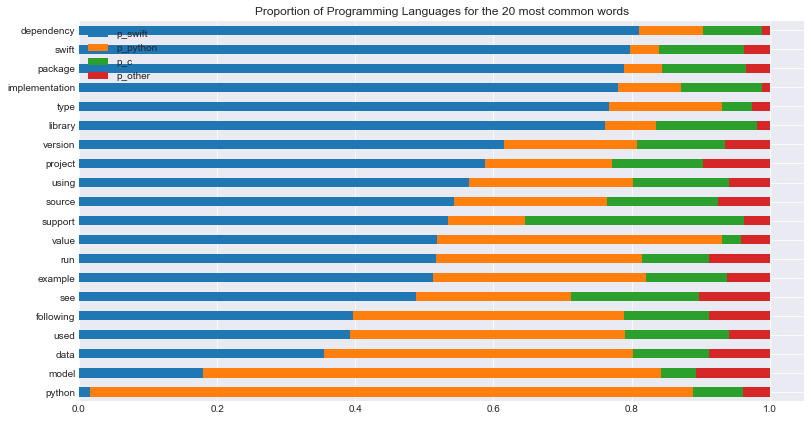

In [35]:
# figure out the percentage of language in words
(word_counts
 .assign(p_swift = word_counts.swift / word_counts['all'],
         p_python = word_counts.python / word_counts['all'],
         p_c = word_counts.c / word_counts['all'],
         p_other = word_counts.other / word_counts['all'])
 .sort_values(by = 'all')
 [['p_swift', 'p_python', 'p_c', 'p_other']]
 .tail(20)
 .sort_values('p_swift')
 .plot.barh(stacked=True))

plt.title('Proportion of Programming Languages for the 20 most common words');

---

## Explore bigrams by language

### Swift Bigrams

In [36]:
swift_bigrams = (pd.Series(nltk.ngrams(swift_words, 2))
                      .value_counts()
                      .head(20))
swift_bigrams.head(20)

(swift, package)              64
(standard, library)           36
(package, manager)            35
(distributed, actor)          33
(swift, project)              30
(swift, import)               27
(backend, implementation)     27
(logging, backend)            26
(please, see)                 24
(command, line)               23
(public, api)                 23
(header, field)               23
(icloud, container)           22
(make, sure)                  22
(metric, backend)             22
(swift, let)                  19
(log, message)                19
(like, swift)                 18
(swift, numerics)             18
(protocol, implementation)    18
dtype: int64

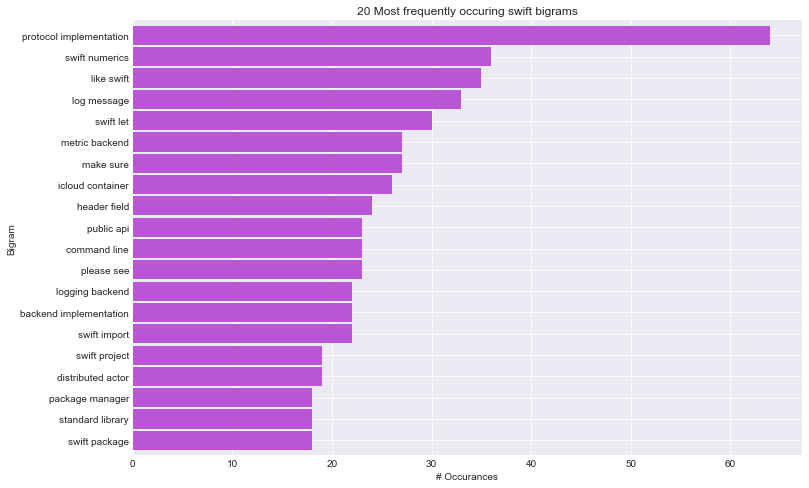

In [37]:
# Vizualize top Swift Bigrams
swift_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring swift bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = swift_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


### Python Bigrams

In [38]:
python_bigrams = (pd.Series(nltk.ngrams(python_words, 2))
                      .value_counts()
                      .head(20))
python_bigrams.head(20)

(data, parameter)                                          28
(bounding, box)                                            26
(camera, trajectory)                                       23
(following, command)                                       18
(pip, install)                                             18
(command, python)                                          15
(arg, verify)                                              15
(example, verify)                                          15
(python, trainpy)                                          15
(hypersim, dataset)                                        15
(scenenames, ai00)                                         14
(bash, python)                                             14
(getting, started)                                         14
(datasetdir, volumesportableharddriveevermotiondataset)    13
(question, answering)                                      13
(neural, network)                                          13
(xml, el

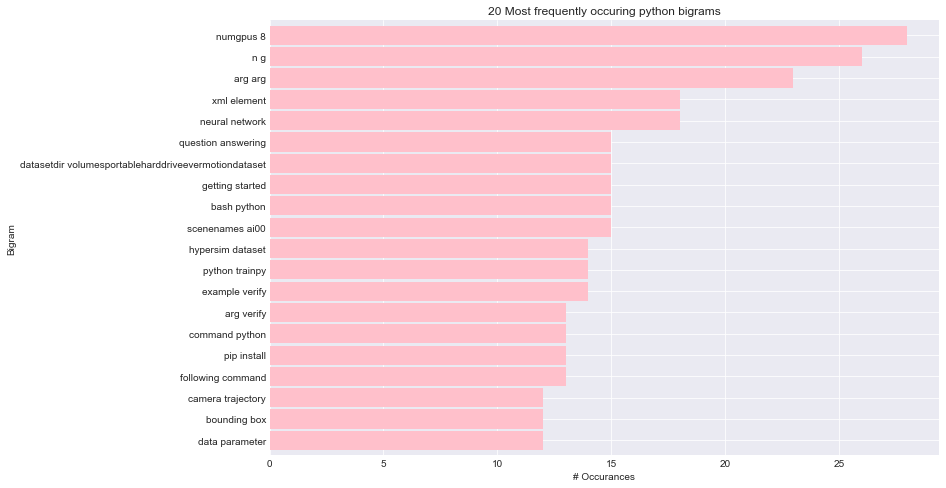

In [39]:
python_bigrams.sort_values().plot.barh(color = 'pink', width = .9, figsize = (12, 8))

plt.title('20 Most frequently occuring python bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = python_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

Go back and filter out the &#9 thing

## C Bigrams

In [40]:
c_bigrams = (pd.Series(nltk.ngrams(c_words, 2))
                      .value_counts()
                      .head(20))

c_bigrams.head()

(swift, crypto)    47
(turi, create)     12
(command, line)    10
(open, source)      9
(user, level)       9
dtype: int64

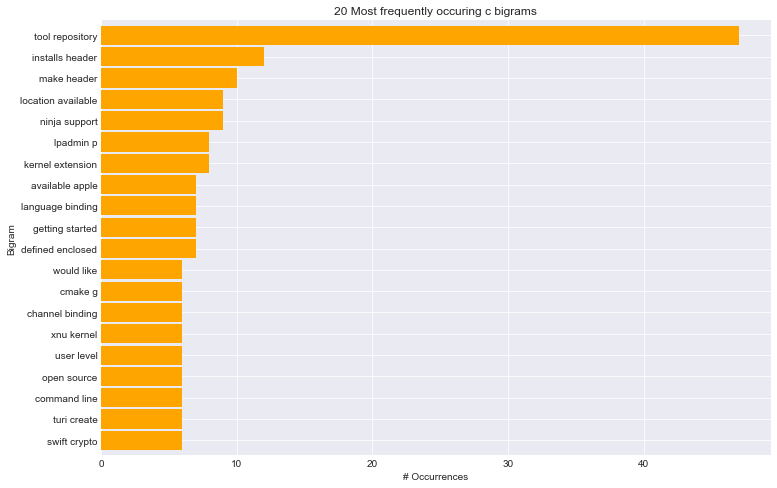

In [41]:
c_bigrams.sort_values().plot.barh(color = 'orange', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring c bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurrences')

# make the labels pretty
ticks, _ = plt.yticks()
labels = c_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


### Other Bigrams

In [53]:
other_bigrams = (pd.Series(nltk.ngrams(other_words, 2))
                      .value_counts()
                      .head(20))

other_bigrams.head()

(password, manager)      18
(ml, compute)            15
(getting, started)        8
(pull, request)           8
(project, maintainer)     6
dtype: int64

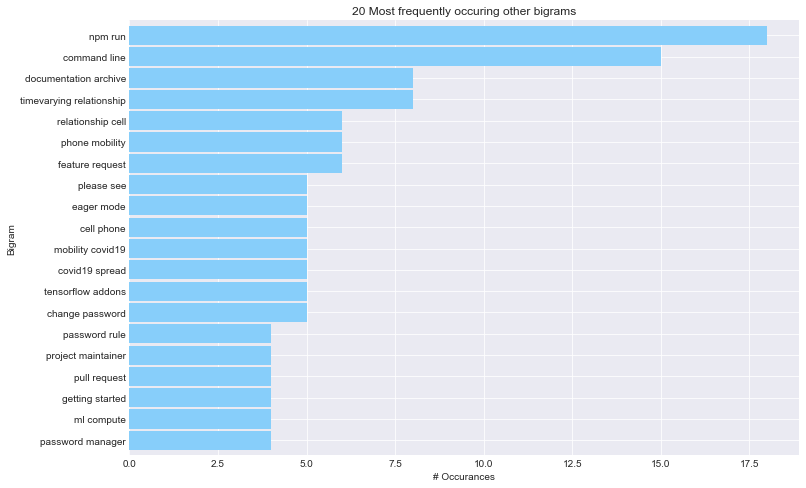

In [43]:
other_bigrams.sort_values().plot.barh(color = 'lightskyblue', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring other bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = other_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


---

## Word Clouds

Vizualize most common words by language family

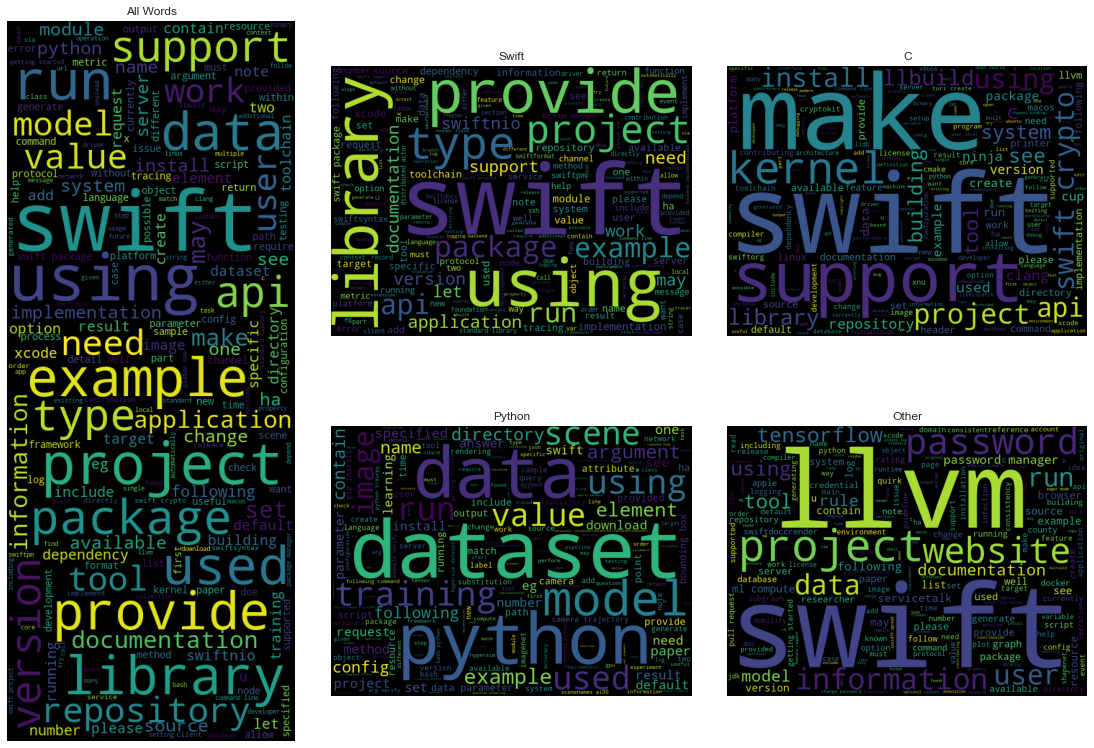

In [44]:
# Create word clouds for all words and language families
all_cloud = WordCloud(background_color = 'black', height = 1000, width = 400).generate(' '.join(all_words))
swift_cloud = WordCloud(background_color = 'black', height = 600, width = 800).generate(' '.join(swift_words))
python_cloud = WordCloud(background_color = 'black', height = 600, width = 800).generate(' '.join(python_words))
c_cloud = WordCloud(background_color = 'black', height = 600, width = 800).generate(' '.join(c_words))
other_cloud = WordCloud(background_color = 'black', height = 600, width = 800).generate(' '.join(other_words))

plt.figure(figsize = (10, 10))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5]), plt.axes([1.05, .5, .5, .5]),
      plt.axes([1.05, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(swift_cloud)
axs[2].imshow(python_cloud)
axs[3].imshow(c_cloud)
axs[4].imshow(other_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Swift')
axs[2].set_title('Python')
axs[3].set_title('C')
axs[4].set_title('Other')

for ax in axs: ax.axis('off')

### Takeaways
- Interesting that swift is still a common word in Other and C
  - Sizes in word clouds not to scale, look at raw counts


---

## Modeling

### Establish Baseline

The most common language is swift, so our baseline model would predict that all the repositories are coded in swift

In [45]:
# baseline
df[df['language'] == 'Swift'].language.value_counts()/sum(df.language.value_counts())

Swift    0.46
Name: language, dtype: float64

### Split data

- Need to split words in to train / test / split
- For x - start with vectorzed,  lematized words 
- y = target

In [46]:
df.head()

,repo,language,target,original,clean,stemmed,lemmatized
0,apple/llvm-project,LLVM,other,# Apple's fork of llvm-project\n\nThis is Appl...,apple fork llvmproject apple fork llvmproject ...,appl fork llvmproject thi appl fork llvmprojec...,apple fork llvmproject apple fork llvmproject ...
1,apple/swift-argument-parser,Swift,swift,# Swift Argument Parser\n\n## Usage\n\nBegin b...,swift argument parser usage begin declaring ty...,swift argument parser usag begin declar type d...,swift argument parser usage begin declaring ty...
2,apple/swift-docc,Swift,swift,# Swift-DocC\n\nSwift-DocC is a documentation ...,swiftdocc swiftdocc documentation compiler swi...,swiftdocc swiftdocc document compil swift fram...,swiftdocc swiftdocc documentation compiler swi...
3,apple/swift,C++,c,"<img src=""https://swift.org/assets/images/swif...",img srchttpsswiftorgassetsimagesswiftsvg altsw...,img srchttpsswiftorgassetsimagesswiftsvg altsw...,img srchttpsswiftorgassetsimagesswiftsvg altsw...
4,apple/sourcekit-lsp,Swift,swift,# SourceKit-LSP\n\nSourceKit-LSP is an impleme...,sourcekitlsp sourcekitlsp implementation langu...,sourcekitlsp sourcekitlsp implement languag se...,sourcekitlsp sourcekitlsp implementation langu...


In [47]:
# Split X Y
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.lemmatized)
y = df.target


In [48]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)



In [49]:
X_train

<120x9749 sparse matrix of type '<class 'numpy.float64'>'
	with 22973 stored elements in Compressed Sparse Row format>

In [50]:
#Create evaluation dataframe
train = pd.DataFrame(dict(actual=y_train))


In [51]:
X_train.shape

(120, 9749)

In [52]:
from lazypredict.Supervised import LazyClassifier


/opt/homebrew/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


XGBoostError: XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed (vcomp140.dll or libgomp-1.dll for Windows, libomp.dylib for Mac OSX, libgomp.so for Linux and other UNIX-like OSes). Mac OSX users: Run `brew install libomp` to install OpenMP runtime.
  * You are running 32-bit Python on a 64-bit OS
Error message(s): ["dlopen(/Users/jaredgodar/.local/lib/python3.8/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib\n  Referenced from: /Users/jaredgodar/.local/lib/python3.8/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file)"]


---

# To - Do

- [x] Go back and add corpus specific stopwords to the prepare.py file and re-run notebook
- [ ] Get clarification on train / *validate* / test
- [ ] Make a new environment and get lazypredict classifier installed and working and feed it something from this to see how it does
- [ ] Update trello board
- [x] Communicate proposed plan for tomorrow to team
- [ ] Ask instructors about file organization within repos and how to call / import / use files in different folders outide root